# Modeling orogenic system using FastScape: 5. Response to cyclic climate

![Henry Mountains](HenryMountains.jpg "Henry Mountains")

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# plt.style.use('dark_background')

import xsimlab as xs
import xarray as xr

%load_ext xsimlab.ipython

from fastscape.models import basic_model

Here we are going to see how the source area (the mountain) reacts to cyclic perturbation in climate.

To investigate how a system respond to change, it is quite common to impose a prediodic forcing and compare it to the response in terms of amplitude and phase. Note that one should always try to work with *relative* amplitudes and the phase )or time lag) should be compared to the period of forcing.

In [2]:
spl_model = basic_model.drop_processes("diffusion")

We are going to run the model for 200 time steps. The first 100 steps will be under constant climate, which will allow the mountain to reach steady-state between uplift and erosion. During the next 100 time steps, the climate is assumed to vary as a sime function of time with a given period. To make sure that the mountain has reacted to a few periods of forcing, we will set the length of the second part of the model to 5 times the period of forcing.

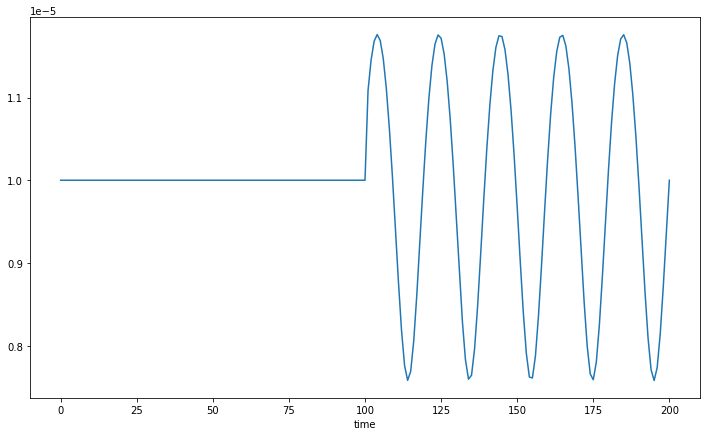

In [3]:
m = 0.4  # area exponent in SPL
n = 1  # slope exponent in SPL
Kf = 1e-5  # rate coefficient in SPL
U = 1e-3  # uplift rate
L = 1e5

nstep = 201  # total number of steps
neq = 101  # number of steps to reach steady-state

teq = 1e7  # time to reach steady-state
period = 1e6  # period of climatic forcing
tfinal = teq + 5 * period  # final time

# Here we build the time array (note that not all time steps are of the same length)
tim1 = np.linspace(0, teq, 101)
tim2 = np.linspace(teq + period / 10, tfinal, 100)
tim = np.concatenate((tim1, tim2))

# build precipitation array
precip = 1 + 0.5 * np.sin(2 * np.pi * (tim - teq) / period)

# build Kf array and transform it into an xarray of dimension 'time'
Kf_tim = np.where(tim > teq, Kf * precip ** m, Kf)
Kf_xr = xr.DataArray(data=Kf_tim, dims="time")

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=True, figsize=(12, 7))

Kf_xr.plot()

In [4]:
# %create_setup spl_model --default --verbose
import xsimlab as xs

ds_in = xs.create_setup(
    model=spl_model,
    clocks={"time": tim},
    input_vars={
        # nb. of grid nodes in (y, x)
        "grid__shape": [101, 101],
        # total grid length in (y, x)
        "grid__length": [L, L],
        # node status at borders
        "boundary__status": ["fixed_value", "core", "looped", "looped"],
        # uplift rate
        "uplift__rate": U,
        # random seed
        "init_topography__seed": None,
        # bedrock channel incision coefficient
        "spl__k_coef": Kf_xr,
        # drainage area exponent
        "spl__area_exp": m,
        # slope exponent
        "spl__slope_exp": n,
    },
    output_vars={"topography__elevation": "time"},
)

In [5]:
import zarr

zgroup = zarr.group("output.zarr", overwrite=True)

In [6]:
with xs.monitoring.ProgressBar():
    ds_out = ds_in.xsimlab.run(model=spl_model, store=zgroup)

             0% | initialize 

In [7]:
from ipyfastscape import TopoViz3d

app = TopoViz3d(ds_out, canvas_height=500, time_dim="time")

app.components["background_color"].set_color("lightgray")
app.components["vertical_exaggeration"].set_factor(5)
app.components["timestepper"].go_to_time(ds_out.time[-1])

app.show()

Output(layout=Layout(height='540px'))

The flux of material, $\phi$, coming out of the orogen can be calculated according to:

$$\phi=\frac{U-<\frac{\partial h}{\partial t}>}{U}$$

(10000000.0, 15000000.0)

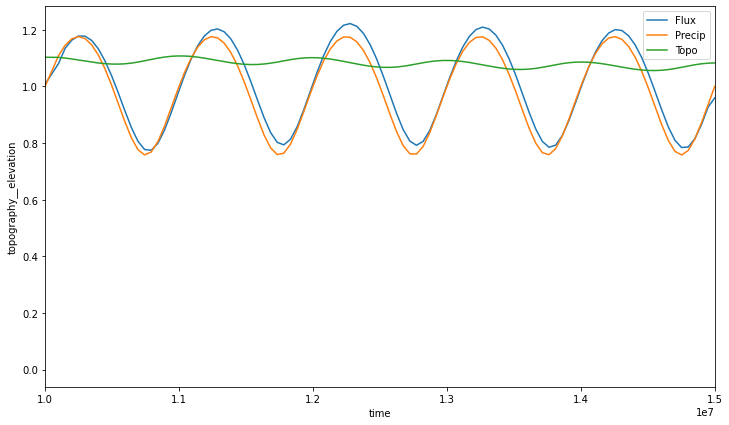

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=True, figsize=(12, 7))

((ds_out.uplift__rate - ds_out.topography__elevation.differentiate("time").mean(("x", "y"))) / ds_out.uplift__rate
).plot(ax=ax, label="Flux")
(ds_out.spl__k_coef / Kf).plot(ax=ax, label="Precip")
(ds_out.topography__elevation.mean(("x", "y")) / ds_out.topography__elevation.mean()).plot(ax=ax, label="Topo")

ax.legend()
ax.set_xlim((teq,tfinal))

We compute the relative amplitude of the forcing and the response

In [9]:
mid = 101
flux = ((ds_out.uplift__rate- ds_out.topography__elevation.differentiate("time").mean(("x", "y"))) / ds_out.uplift__rate).values
amp_flux = flux[mid:].max() - flux[mid:].min()
amp_forcing = precip[mid:].max() - precip[mid:].min()

print('forcing:',amp_forcing,'response:', amp_flux)


forcing: 0.9999144065140239 response: 0.44748404241879236


We compute the time lag normalized by the period

In [10]:
print('time lag:',(tim[np.argmax(precip[180:])+180] - tim[np.argmax(flux[180:])+180])/period)

time lag: 0.0


To understand these results, see [Braun et al, 2015](https://esurf.copernicus.org/articles/3/1/2015/esurf-3-1-2015.pdf) where the response time of an orogen is defined as:

$$\tau=\frac{L^{1-mp/n}}{K_f^{1/n}U^{1-1/n}k^{m/n}}$$

In [11]:
p = 2
k = 0.67
tau = ds_out.grid__length[0].values**(1-m*p/n)/Kf**(1/n)/U**(1-1/n)/k**(m/n)
print(tau/1e6,'Myr')

1.1737350642419089 Myr


You should now rerun this notebook for different values of the forcing (climate) period and amplitude and understand the solution you obtain. You will see that for fast cyclic variations in climate (in comparison to the response time of the orogen), the flux will "react" with an amplification factor given by $m$ the drainage area exponent in the SPL and with no offset. As the period of forcing increases to becomse larger than the response time of the orogen, the amplitude of the flux response will progressively decreased and the time lag will increase to reach a quarter cycle/period. This is explained in details in [Braun et al, 2015](https://esurf.copernicus.org/articles/3/1/2015/esurf-3-1-2015.pdf).